<a href="https://colab.research.google.com/github/Annomaliaa/CNN/blob/master/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import tensorflow as tf
#from tensorflow.keras import Sequential
#from tensorflow.keras.callbacks import LambdaCallback 
#import tensorflow.keras.layers as L
#from tensorflow.keras.datasets import mnist, cifar10
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.0 MB/s eta 0:00:00


In [3]:
import dill

In [4]:
from google.colab import drive


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, pickle_module=dill, map_location=torch.device('cpu'))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"]) 
    return model


In [7]:
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [8]:
  transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
      ])

  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
  ])

In [9]:
dataloader = datasets.CIFAR10

In [10]:
trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
#trainset = (x_train, y_train)
testset = dataloader(root='./data', train=False, download=False, transform=transform_test)
#testset = (x_test, y_test)
x_train = trainset.data
y_train = trainset.targets
x_test = testset.data
y_test = testset.targets

100%|██████████| 170498071/170498071 [00:14<00:00, 11725421.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
import torch.utils.data as data
BATCH_SIZE = 128
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
labels = 10
label_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [13]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 

In [14]:
# Convert y_train to one-hot encoded format
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=nb_classes).numpy()

# Convert y_test to one-hot encoded format
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=nb_classes).numpy()

print_shapes(x_train, x_test, y_train, y_test)

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, height, width, channels))
x_test = x_test.reshape((-1, height, width, channels))

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)



In [15]:
NET_NAME = "resnet20-decomp-TT"
WEIGHTS_PATH = f'/content/drive/My Drive/CIFAR10/fine_tuned/{NET_NAME}.pth'
model = load_checkpoint(WEIGHTS_PATH)

In [22]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch

# Load the pre-trained ResNet-18 model
model = model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Load the image of frog or dog
image_path = f'/content/drive/My Drive/CIFAR10/ATMC/emanuel-AKYjr-kmYtQ-unsplash.jpg'
image = Image.open(image_path)

print(image.size)

# Check the number of channels in the image
num_channels = len(image.getbands())

transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
  ])


# Apply the transformations

input_image = transform(image).unsqueeze(0)
image = input_image.to(device)

model.eval()



# Make predictions
with torch.no_grad():
    predictions = model(image)

label = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']


print(predictions)
predicted_class = torch.argmax(predictions).item()

print(predicted_class)

(4068, 2199)
tensor([[ 8.5302, -4.3004,  5.5711, -0.9800,  1.9730, -3.9284, -1.3962, -3.6276,
         -0.1324, -1.7095]], device='cuda:0')
0


In [17]:
import torch
import torch.nn.functional as F

# Function to calculate adversary noise
def generate_adversary(image, label):
    device = torch.device('cpu') 
    image = torch.from_numpy(image)
    image = image.to(torch.float32)
    image = image.clone().detach().requires_grad_(True)

    #Image shape expected input[1, 32, 32, 3] to have 3 channels, but got 32 channels 
    image = torch.transpose(image, 1, 3)
    prediction = model(image)
    #Prediction and label shapes need to match
    print("Predictions",prediction.shape)
    print("Labels", label.size)
    label = torch.from_numpy(label)
    label = label.to(torch.float32)

    loss = F.mse_loss(prediction, label, size_average=None, reduce=None, reduction='mean')

    print("Loss", loss)

    print("Predictions:", prediction.dtype)
    print("Label:", label.dtype)
    print("Loss:", loss.dtype)
    
    print("Image:", image.dtype)


    gradient = torch.autograd.grad(loss, image)[0]

    print("Gradient:", gradient.dtype)

    print("Gradient", gradient.size)
    sign_grad = torch.sign(gradient)

    return sign_grad

[0 0 0 0 1 0 0 0 0 0]
Prediction from CNN: deer


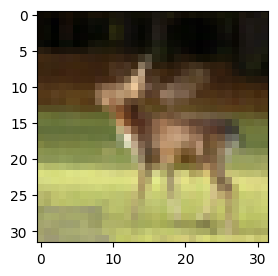

In [18]:
rand_idx = randint(0,49999)
image = x_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]
print(label)

labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

matching_indices = np.where(label == 1)[0]
if len(matching_indices) > 0:
    predicted_label = labels[matching_indices[0]]
    
    print(f'Prediction from CNN: {predicted_label}')
else:
    print('No matching prediction found')

plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [19]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label).numpy()

RuntimeError: ignored

In [ ]:
# Convert perturbations to a PyTorch tensor
perturbations = torch.from_numpy(perturbations)
perturbations = torch.transpose(perturbations, 1, 3)
perturbations = perturbations * 0.1

image = torch.from_numpy(image)

print(type(image))  # <class 'torch.Tensor'>
print(type(perturbations))  # <class 'torch.Tensor'>

adversarial = image + perturbations

print(adversarial.shape)
print(image.shape)

In [ ]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
adversarial = adversarial.reshape(height,width, channels)
ax2.imshow((adversarial))
ax2.set_title("Image with Adversary")
plt.show()


In [ ]:
# Obtain the predictions
image = image.reshape(1, channels, height, width)
print(type(image))
print(image.shape)
normal_predictions = model(image.float()).argmax(dim=1)
adversarial = adversarial.reshape(1, channels, height, width)
adversary_predictions = model(adversarial.float()).argmax(dim=1)

# Convert predictions to label names
normal_label = label_names[normal_predictions.item()]
adversary_label = label_names[adversary_predictions.item()]

# Print the predictions
print(f'Normal Image Prediction: {normal_label}')
print(f"Adversary Prediction: {adversary_label}")

In [ ]:
# Display the images and their predicted labels
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title(f"Original: {normal_label}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title(f"Adversarial: {adversary_label}")
plt.show()

In [ ]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      N = randint(0, 49999)
      label = y_train[N]
      image = x_train[N].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label).numpy()

      print(image.shape, label.shape)
      print(type(image))
      image = np.swapaxes(image, 1, 3)

      adversarial = image + (perturbations * 0.05)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
import os 
directory = '/content/drive/My Drive/CIFAR10/ATMC/'
filename = 'adversarial_dataset.pth'
# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

In [ ]:
x_adversarial, y_adversarial = next(adversary_generator(10000))
torch.save((x_adversarial, y_adversarial), os.path.join(directory, filename))

In [ ]:

model_filepath = os.path.join(directory, filename)
adversarial_dataset = torch.load(model_filepath)

In [ ]:
x_adversarial, y_adversarial = adversarial_dataset
import torch 
import numpy
print(x_adversarial.shape)
print(y_adversarial.shape)

labels_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

rand_idx = randint(0,9999)
image = x_adversarial[rand_idx].reshape((1, height, width, channels))
label = y_adversarial[rand_idx]

matching_indices = np.where(label == 1)[0]
if len(matching_indices) > 0:
    predicted_label = label_names[matching_indices[0]]
    print(f'Prediction from CNN: {predicted_label}')
else:
    print('No matching prediction found')

plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()
# Calculate the accuracy

batch_images = x_adversarial
batch_labels = y_adversarial[1]

batch_images = torch.from_numpy(batch_images)
batch_images = torch.transpose(batch_images, 1, 3)
batch_images = batch_images.to(torch.float32)


# Forward pass to get the predictions
batch_predictions = model(batch_images)

# Calculate the number of correct predictions
_, batch_predicted_labels = torch.max(batch_predictions, dim=1)
correct_predictions += torch.sum(batch_predicted_labels == batch_labels).item()

accuracy = correct_predictions / total_samples

# Print the accuracy
print(f'Accuracy: {accuracy:.2%}')